In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import numpy as np

In [52]:
titanic_data = pd.read_csv('https://github.com/Ultraluxe25/Karpov-Stepik-Introduction-to-DS-and-ML/raw/main/csv/titanic.csv')

In [53]:
X = titanic_data.drop(['PassengerId','Survived', 'Name', 'Ticket', 'Cabin'], axis=1) # убираем ненужные колонки
y = titanic_data.Survived

In [57]:
# конвертируем строковые переменные в булевые,
# т.к. дерево решений умеет работать только с числовыми переменными
X = pd.get_dummies(X)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,38.0,1,0,71.2833,True,False,True,False,False
2,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,35.0,1,0,53.1000,True,False,False,False,True
4,3,35.0,0,0,8.0500,False,True,False,False,True


In [58]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

In [ ]:
tree.plot_tree(clf, filled=True, class_names=['Died', 'Servived'], feature_names=list(X)) 
# получаем огромное дереве, т.к. не ограничили его глубину

In [161]:
from sklearn.model_selection import train_test_split

# разбиваем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [61]:
clf.score(X, y) # средняя точность на выбранных метриках

0.9809203142536476

In [62]:
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.9781879194630873

In [63]:
clf.score(X_test, y_test) # разница в скорах большая, значит модель переобучилась.

0.7559322033898305

### Глубина дерева

In [67]:
# выясним, как ведут себя значения скоров для трейна и теста при разной глубине дерева

max_depth_values = range(1, 25)
scores_data = pd.DataFrame()

for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train) # предсказываем точность классификации на трэин
    test_score = clf.score(X_test, y_test)
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': [test_score]})
    scores_data = pd.concat([scores_data, temp_score_data])

In [68]:
scores_data.head()

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.842282,0.810169


In [69]:
scores_data_long = pd.melt(scores_data,
                           id_vars=['max_depth'],
                           value_vars=['train_score', 'test_score'],
                           var_name='set_type',
                           value_name='score')
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.842282


<Axes: xlabel='max_depth', ylabel='score'>

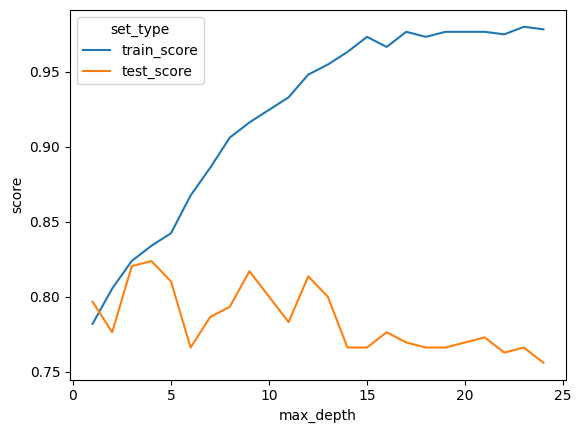

In [70]:
sns.lineplot(x='max_depth', y='score',hue='set_type', data=scores_data_long)

Анализ графика:

train score:
- растет с увеличением глубины дерева
- что не всегда ведет к нахождению общих закономерностей в исследуемых данных

test score:
- изначально невелик (модель еще не доучилась)
- на промежутке 3-5 score максимален (оптимальное состояние: закономерность с изученных данных переносится на новые)
- с дальнейшим увеличением глубины test score начинает падать (переход от недообученности к переобученности)

### Кроссвалидация

In [71]:
from sklearn.model_selection import cross_val_score

In [72]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [73]:
# 5 значений - это точность, которую показал классификатор, разбив X_train y_train на 5 равных кусочков
# сначала обучился на первых четырех и предсказал пятый
# потом обучился на всех, кроме 4-го и предсказал 4-й и т.д...
cross_val_score(clf, X_train, y_train, cv=5)

array([0.76666667, 0.82352941, 0.76470588, 0.75630252, 0.80672269])

In [75]:
cross_val_score(clf, X_train, y_train, cv=5).mean() # средняя точность на кросвалидации

0.7835854341736695

In [77]:
# добавим кросвалидация
max_depth_values = range(1, 25)
scores_data = pd.DataFrame()

for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)

    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()

    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score],
                                    'cross_val_score': mean_cross_val_score})
    scores_data = pd.concat([scores_data, temp_score_data])

In [83]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'],
                           value_vars=['train_score', 'test_score', 'cross_val_score'],
                           var_name='set_type',
                           value_name='score')
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.842282


<Axes: xlabel='max_depth', ylabel='score'>

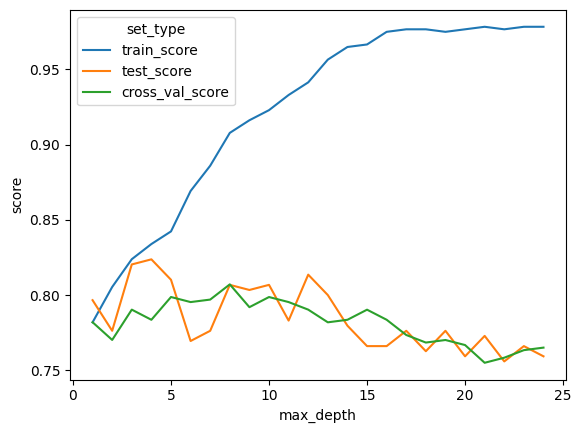

In [80]:
sns.lineplot(x='max_depth', y='score',hue='set_type', data=scores_data_long)

In [84]:
# глубина дерева, при которой достигается максимальное значение mean_cross_val_score:
scores_data_long.query("set_type == 'cross_val_score'").sort_values('score', ascending=False).head(1)

,max_depth,set_type,score
55,8,cross_val_score,0.807101


In [86]:
# на основе этой глубины заводим бест классифаир
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=8)
best_clf.fit(X_train, y_train) # обучим его на тренировочных данных
# Протестируем точность (процент правильных ответов):
best_clf.score(X_test, y_test)

0.8135593220338984

### домашка

In [156]:
iris_train = pd.read_csv("https://stepik.org/media/attachments/course/4852/train_iris.csv", index_col=0)
iris_test = pd.read_csv("https://stepik.org/media/attachments/course/4852/test_iris.csv", index_col=0)


In [157]:
X_train_iris = iris_train.drop(["species"], axis=1)
X_test_iris = iris_test.drop(["species"], axis=1)
y_train_iris = iris_train.species
y_test_iris = iris_test.species

In [158]:
max_depth_values = range(1, 100)
scores_iris_data = pd.DataFrame()
rs = np.random.seed(0)
for max_depth in max_depth_values:
    
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=rs)
    clf.fit(X_train_iris, y_train_iris)

    train_score = clf.score(X_train_iris, y_train_iris)
    test_score = clf.score(X_test_iris, y_test_iris)
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score]})
    scores_data = pd.concat([scores_data, temp_score_data])

In [159]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'],
                           value_vars=['train_score', 'test_score'],
                           var_name='set_type',
                           value_name='score')
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.70
1,2,train_score,0.97
2,3,train_score,0.99
3,4,train_score,1.00
4,5,train_score,1.00


<Axes: xlabel='max_depth', ylabel='score'>

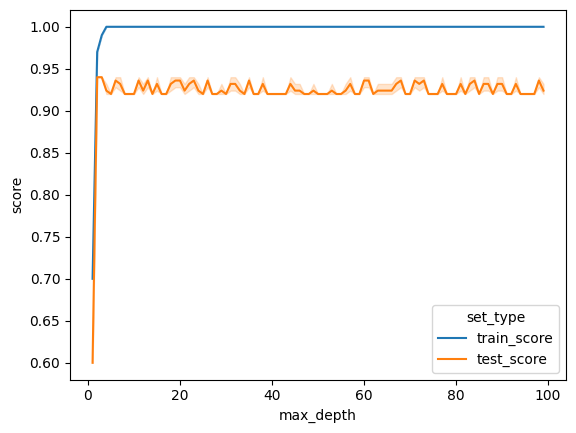

In [160]:
sns.lineplot(x='max_depth', y='score',hue='set_type', data=scores_data_long)

In [148]:
dogs_n_cats_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/dogs_n_cats.csv')
dogs_n_cats_train.head()

,Длина,Высота,Шерстист,Гавкает,Лазает по деревьям,Вид
0,15,18.0,1,1,0,собачка
1,20,24.0,1,0,0,собачка
2,34,40.8,1,1,0,собачка
3,26,31.2,1,1,0,собачка
4,16,19.2,1,1,0,собачка


In [149]:
X_dogs_train = dogs_n_cats_train.drop(['Вид'], axis=1)
y_dogs_train = dogs_n_cats_train.Вид

### продолжение титаника или подбор параметров

In [150]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_dogs_train, y_dogs_train)
clf.score(X_dogs_train, y_dogs_train) # 1

1.0

In [151]:
dogs_n_cats_test = pd.read_json('dataset_209691_15.txt') 
# Предсказание на тестовых данных 
y_pred = clf.predict(dogs_n_cats_test)

# Подсчет значений в предсказанных данных
(y_pred == 'собачка').sum()

51

In [152]:
from sklearn.model_selection import GridSearchCV

In [164]:
clf = tree.DecisionTreeClassifier()
params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 10)}
grid_search_cv_clf = GridSearchCV(clf, params, cv=5)

In [165]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10)})

In [166]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 6}

In [167]:
best_clf = grid_search_cv_clf.best_estimator_

In [168]:
best_clf

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [169]:
best_clf.score(X_test, y_test)

0.7661016949152543

In [170]:
from sklearn.metrics import precision_score, recall_score

In [171]:
y_pred = best_clf.predict(X_test)
precision_score(y_test, y_pred)

0.8

In [172]:
recall_score(y_test, y_pred)

0.5666666666666667

<Axes: >

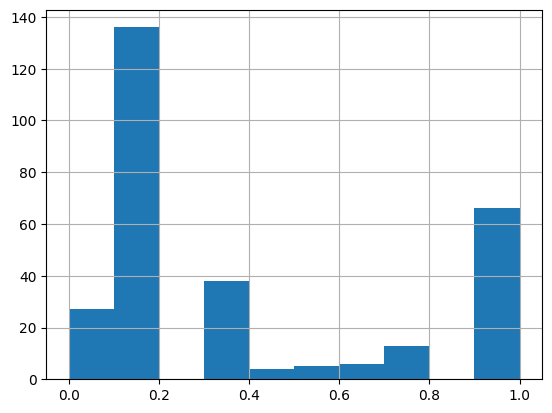

In [177]:
y_predicted_prob = best_clf.predict_proba(X_test)
pd.Series(y_predicted_prob[:, 1]).hist()


In [178]:
import numpy as np

In [191]:
y_pred = np.where(y_predicted_prob[:, 1] > 0.9, 1, 0)

In [192]:
precision_score(y_test, y_pred)

0.90625

In [193]:
recall_score(y_test, y_pred)

0.48333333333333334

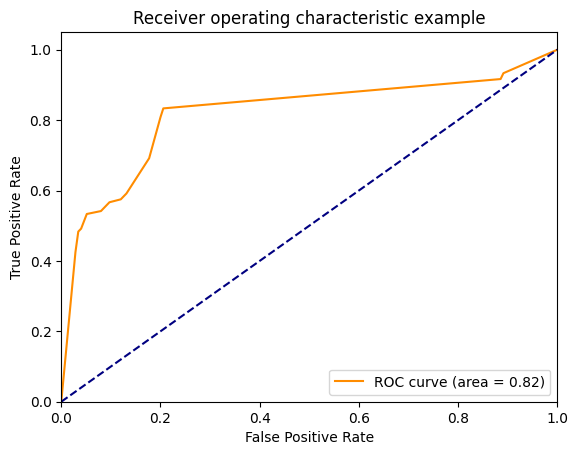

In [194]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()